## Network Optimization exam June 04, 2019 R2

## Exercise 1

The  graph ``graph04062019R2.gml``   contains  a  set  of potential customers that a telecom company can connect with a network rooted in node 1.

Each location(node) $u$ has associated a revenue \[``revenue`` attribute in the graph\] and  each  edge $uv$ has a connection  cost  \[``cost``attribute  in  the  graph\].

The company has a two years investment plan with the following budget:

- **Year 1**: 6000 Euro
- **Year 2**: 3000 Euro

Compare the following deployment strategies:

1. The company implements the network in the first year with a budget of 9000  Euro, by obtaining  an  anticipation  of  the  Year  2 budget.  The anticipation will cost 400 Euro of interest. 
2. The  company  deploys  the  network  in  two  years  by  respecting  the budget constraint for each year.

## Strategy 1

The network design model we need is the Prize Collecting Steiner Tree with budget constraint.
Thanks to the budget anticipation, the overall budget is 9000 Euro but from the final profit we have
to subtract 400 Euro for the cost of the budget anticipation

In [27]:
import networkx as nx
import gurobi as gb
import os
import matplotlib.pyplot as plt

#
# Drawing 
# functions
#

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40
    

In [28]:
# 
# Read the graph in the graphML format
#

args.filename = 'graph04062019R2.gml'

args.figsize = 15,25

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 25 nodes and 300 edges


## Define the bidirected graph D from G

In [29]:
D = G.to_directed()

### Check that the graph contains the required attributes

In [30]:
G.nodes(data=True)

NodeDataView({1: {'population': 2319, 'x': 23, 'revenue': 982, 'y': 6}, 2: {'population': 6161, 'x': 17, 'revenue': 381, 'y': 24}, 3: {'population': 1798, 'x': 10, 'revenue': 722, 'y': 25}, 4: {'population': 8475, 'x': 7, 'revenue': 201, 'y': 18}, 5: {'population': 6818, 'x': 12, 'revenue': 508, 'y': 42}, 6: {'population': 1289, 'x': 1, 'revenue': 633, 'y': 17}, 7: {'population': 6455, 'x': 25, 'revenue': 458, 'y': 23}, 8: {'population': 2036, 'x': 29, 'revenue': 421, 'y': 27}, 9: {'population': 1821, 'x': 5, 'revenue': 330, 'y': 34}, 10: {'population': 7761, 'x': 20, 'revenue': 652, 'y': 40}, 11: {'population': 6200, 'x': 11, 'revenue': 929, 'y': 29}, 12: {'population': 9405, 'x': 15, 'revenue': 1044, 'y': 33}, 13: {'population': 2085, 'x': 29, 'revenue': 945, 'y': 45}, 14: {'population': 5058, 'x': 19, 'revenue': 471, 'y': 11}, 15: {'population': 5997, 'x': 26, 'revenue': 210, 'y': 27}, 16: {'population': 2807, 'x': 5, 'revenue': 846, 'y': 16}, 17: {'population': 7726, 'x': 14, 'reve

In [31]:
G.nodes(data=True)

NodeDataView({1: {'population': 2319, 'x': 23, 'revenue': 982, 'y': 6}, 2: {'population': 6161, 'x': 17, 'revenue': 381, 'y': 24}, 3: {'population': 1798, 'x': 10, 'revenue': 722, 'y': 25}, 4: {'population': 8475, 'x': 7, 'revenue': 201, 'y': 18}, 5: {'population': 6818, 'x': 12, 'revenue': 508, 'y': 42}, 6: {'population': 1289, 'x': 1, 'revenue': 633, 'y': 17}, 7: {'population': 6455, 'x': 25, 'revenue': 458, 'y': 23}, 8: {'population': 2036, 'x': 29, 'revenue': 421, 'y': 27}, 9: {'population': 1821, 'x': 5, 'revenue': 330, 'y': 34}, 10: {'population': 7761, 'x': 20, 'revenue': 652, 'y': 40}, 11: {'population': 6200, 'x': 11, 'revenue': 929, 'y': 29}, 12: {'population': 9405, 'x': 15, 'revenue': 1044, 'y': 33}, 13: {'population': 2085, 'x': 29, 'revenue': 945, 'y': 45}, 14: {'population': 5058, 'x': 19, 'revenue': 471, 'y': 11}, 15: {'population': 5997, 'x': 26, 'revenue': 210, 'y': 27}, 16: {'population': 2807, 'x': 5, 'revenue': 846, 'y': 16}, 17: {'population': 7726, 'x': 14, 'reve

In [32]:
G.edges(data=True)

EdgeDataView([(1, 2, {'cost': 1897}), (1, 3, {'cost': 2302}), (1, 4, {'cost': 1998}), (1, 5, {'cost': 3764}), (1, 6, {'cost': 2455}), (1, 7, {'cost': 1713}), (1, 8, {'cost': 2180}), (1, 9, {'cost': 3331}), (1, 10, {'cost': 3409}), (1, 11, {'cost': 2590}), (1, 12, {'cost': 2814}), (1, 13, {'cost': 3949}), (1, 14, {'cost': 638}), (1, 15, {'cost': 2126}), (1, 16, {'cost': 2059}), (1, 17, {'cost': 988}), (1, 18, {'cost': 2640}), (1, 19, {'cost': 3748}), (1, 20, {'cost': 3080}), (1, 21, {'cost': 502}), (1, 22, {'cost': 511}), (1, 23, {'cost': 3402}), (1, 24, {'cost': 1607}), (1, 25, {'cost': 99}), (2, 3, {'cost': 708}), (2, 4, {'cost': 1168}), (2, 5, {'cost': 1873}), (2, 6, {'cost': 1750}), (2, 7, {'cost': 802}), (2, 8, {'cost': 1235}), (2, 9, {'cost': 1566}), (2, 10, {'cost': 1628}), (2, 11, {'cost': 779}), (2, 12, {'cost': 917}), (2, 13, {'cost': 2414}), (2, 14, {'cost': 1319}), (2, 15, {'cost': 945}), (2, 16, {'cost': 1445}), (2, 17, {'cost': 2219}), (2, 18, {'cost': 1045}), (2, 19, {'co

## Formulation with positional variables $u_i$

$$
\begin{align}
\max &  - \sum_{(i,j) \in A} c_{ij} x_{ij} + \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\setminus\{0\}\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$

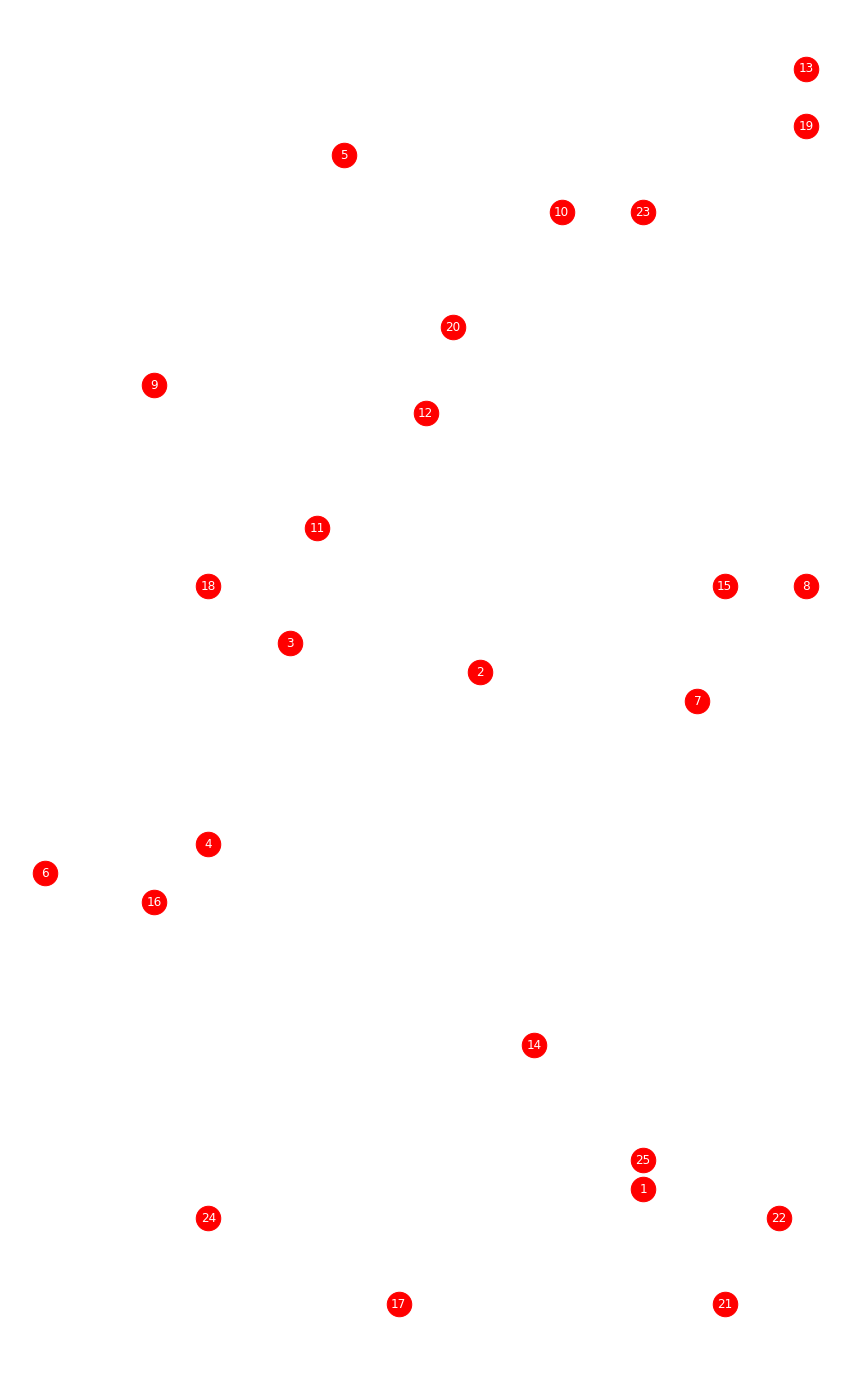

In [33]:
root = 1

pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}
DrawInitG(G)



## Model implementation

In [36]:
pcst = gb.Model()


#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst.ModelSense = gb.GRB.MAXIMIZE


#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

pcst.update()


#
# Precedence constraints (MTZ constraints)
#

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()),
                name = 'MTZ')

pcst.update()


#
# Connectivity constraints
#

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 

#
# Budget constraint
#

budget = 9000

costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

pcst.addConstr(x.prod(costs) <= budget, 'Budget')

pcst.update() 





In [37]:
pcst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1202 rows, 650 columns and 4153 nonzeros
Model fingerprint: 0xfc8e9db6
Variable types: 25 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 9e+03]
Found heuristic solution: objective 982.0000000
Presolve removed 50 rows and 26 columns
Presolve time: 0.01s
Presolved: 1152 rows, 624 columns, 3987 nonzeros
Variable types: 24 continuous, 600 integer (600 binary)

Root relaxation: objective 5.941769e+03, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5941.76923    0   26  982.00000 5941.76923   505%     -    0s
H    0     0                    1254.0000000 5941

## Draw the optimal solution

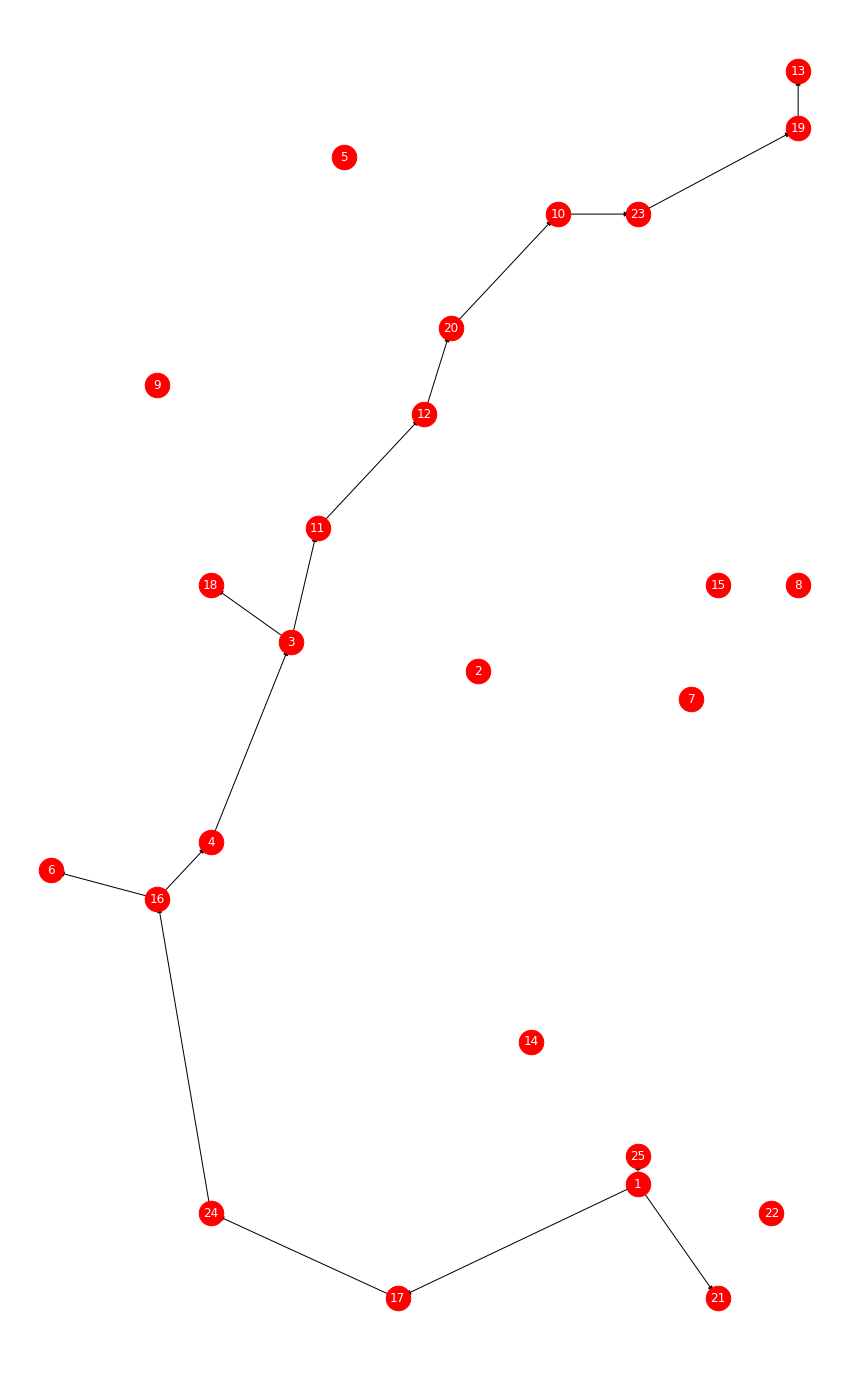

In [12]:
args.figsize = (15,25)

DrawSol(D,x)




## Profit evaluation

The total profit for the first strategy is 3492 - 400 = 3092 Euro

## Strategy 2

$$ \sum_{(i,j) \in A} c_{ij} \cdot x_{ij} \le b $$

## Year 1 network 

The Year 1 is designed with the same PCST model with a budget of Euro 6000

In [38]:
pcst = gb.Model()


#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst.ModelSense = gb.GRB.MAXIMIZE


#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

pcst.update()


#
# Precedence constraints (MTZ constraints)
#

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()),
                name = 'MTZ')

pcst.update()


#
# Connectivity constraints
#

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 

budget = 6000

costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

pcst.addConstr(x.prod(costs) <= budget, 'Budget')

pcst.update() 

pcst.write('pcst_budget.lp')



In [39]:
pcst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1202 rows, 650 columns and 4153 nonzeros
Model fingerprint: 0x6916bbf3
Variable types: 25 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 6e+03]
Found heuristic solution: objective 982.0000000
Presolve removed 122 rows and 26 columns
Presolve time: 0.02s
Presolved: 1080 rows, 624 columns, 5007 nonzeros
Variable types: 24 continuous, 600 integer (600 binary)

Root relaxation: objective 5.883060e+03, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5883.06040    0   26  982.00000 5883.06040   499%     -    0s
H    0     0                    1254.0000000 588

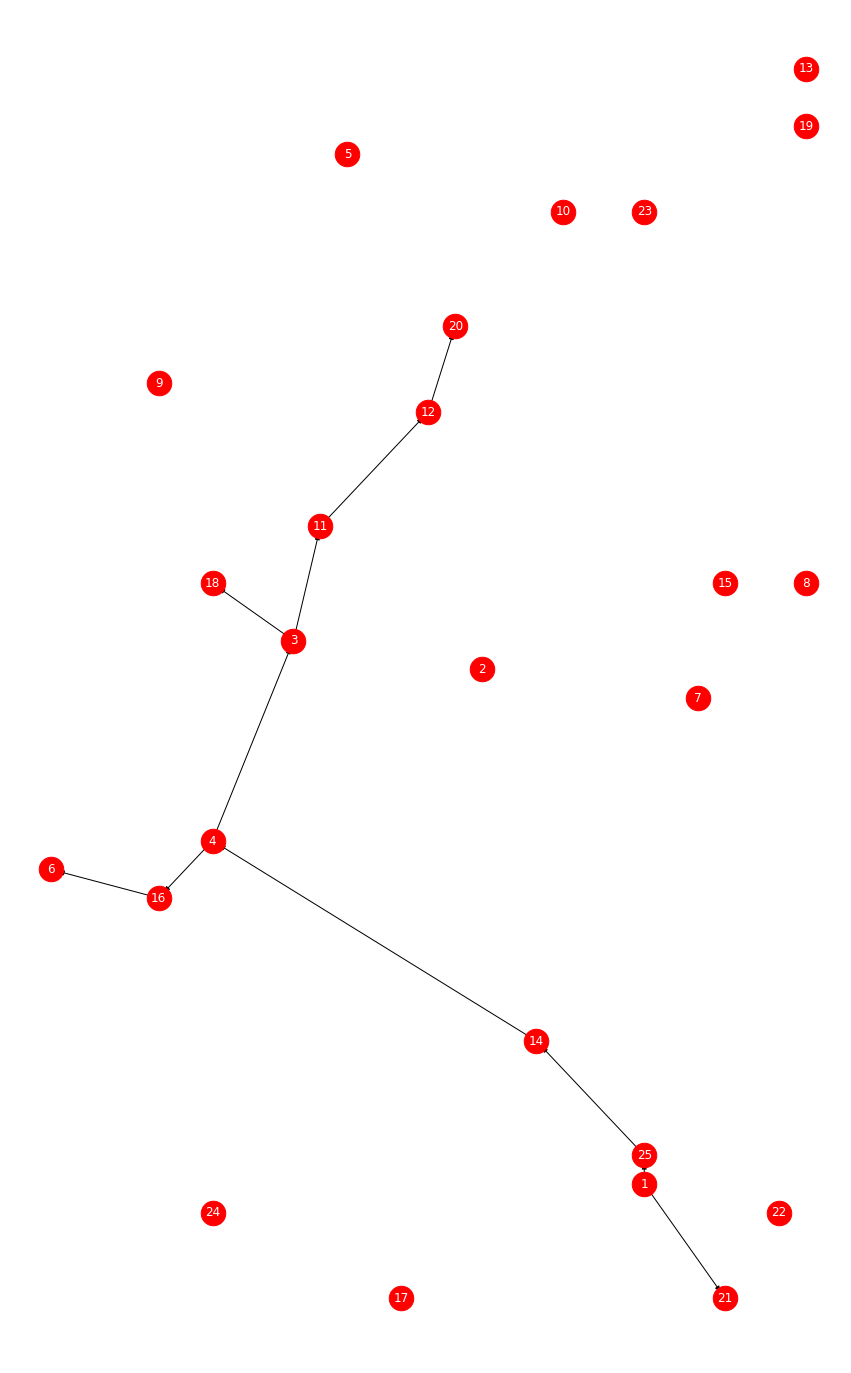

In [15]:
DrawSol(D,x)


### Year 2 network

In this case, you have to design a network that extend the Year 1 network. 

First, assign ``revenue``
zero to all node in the Year 1 network and ``cost`` zero to all edges activated in the Year 1. 

In [40]:
for i in G.nodes():
    if y[i].x > 0:
        G.nodes[i]['revenue']  = 0        
        

In [41]:
for i,j in G.edges():
    if x[i,j].x > 0 or x[j,i].x > 0:
        G[i][j]['cost']  = 0

Regenerate the bidirected graph with the new attribute values

In [42]:
D = G.to_directed()

### Define a new model PCST model for Year 2

Please, note the different variable names to avoid conflicts with the Year 1 model

In [45]:
pcst_2 = gb.Model()

In [46]:
#
# Variables definition
#


x_2 = pcst_2.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

y_2 = pcst_2.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u_2 = pcst_2.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst_2.ModelSense = gb.GRB.MAXIMIZE

In [47]:
#
# Root is in the solution
#

pcst_2.addConstr(y_2[root] == 1, name = 'Fix')

pcst_2.update()

#
# Each node has exactly one incoming arc
#

pcst_2.addConstrs((x_2.sum('*',j) == y_2[j] for j in G.nodes() if j != root), name='Node')

pcst_2.update()


#
# Precedence constraints (MTZ constraints)
#

pcst_2.addConstrs(((G.number_of_nodes() +  1) * x_2[i,j] + u_2[i] - u_2[j] <= G.number_of_nodes() for i,j in D.edges()),
                name = 'MTZ')

pcst_2.update()

#
# Connectivity constraints
#

pcst_2.addConstrs((x_2[j,k] <= y_2[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst_2.update() 

Now, we ensure that the nodes and edges already selected in Year 1 are in the solution (remember, we
                                                                                       have to extend Year 1 network).
                                                                                       
We perform a **variable fixing**:

In [48]:
#
# Variable fixing
#

for i in x:
    if x[i].x > 0.1:
        x_2[i].lb = 1

for j in y:
    if y[j].x > 0.1:
        y_2[j].lb = 1

pcst_2.write('pcst_2.lp')

Now the budget constraint

In [49]:
budget = 3000

costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

pcst_2.addConstr(x_2.prod(costs) <= budget, 'Budget')

pcst_2.update() 

pcst_2.write('pcst_budget.lp')


In [50]:
pcst_2.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1202 rows, 650 columns and 4131 nonzeros
Model fingerprint: 0x5d0e4b2c
Variable types: 25 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 3e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 1058 rows and 509 columns
Presolve time: 0.02s
Presolved: 144 rows, 141 columns, 1552 nonzeros
Variable types: 12 continuous, 129 integer (129 binary)

Root relaxation: objective 1.258172e+03, 35 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1258.17211    0   18   -0.00000 1258.17211      -     -    0s
H    0     0                     206.0000000 117

In [25]:
totalcost = 0

for i,j in D.edges():
        if x_2[i,j].x > 0.1:
            totalcost += D[i][j]['cost']

print ("Total cost", totalcost)

Total cost 1743


## Solution analysis and total profit evaluation

Total profit for strategy 2 is the sum of the profit of Year 1 (2811) and Year 2 (421):

Total profit: 2811 + 421 = 3232.

The best strategy is strategy 2 (3232 > 3092). The final network is the following

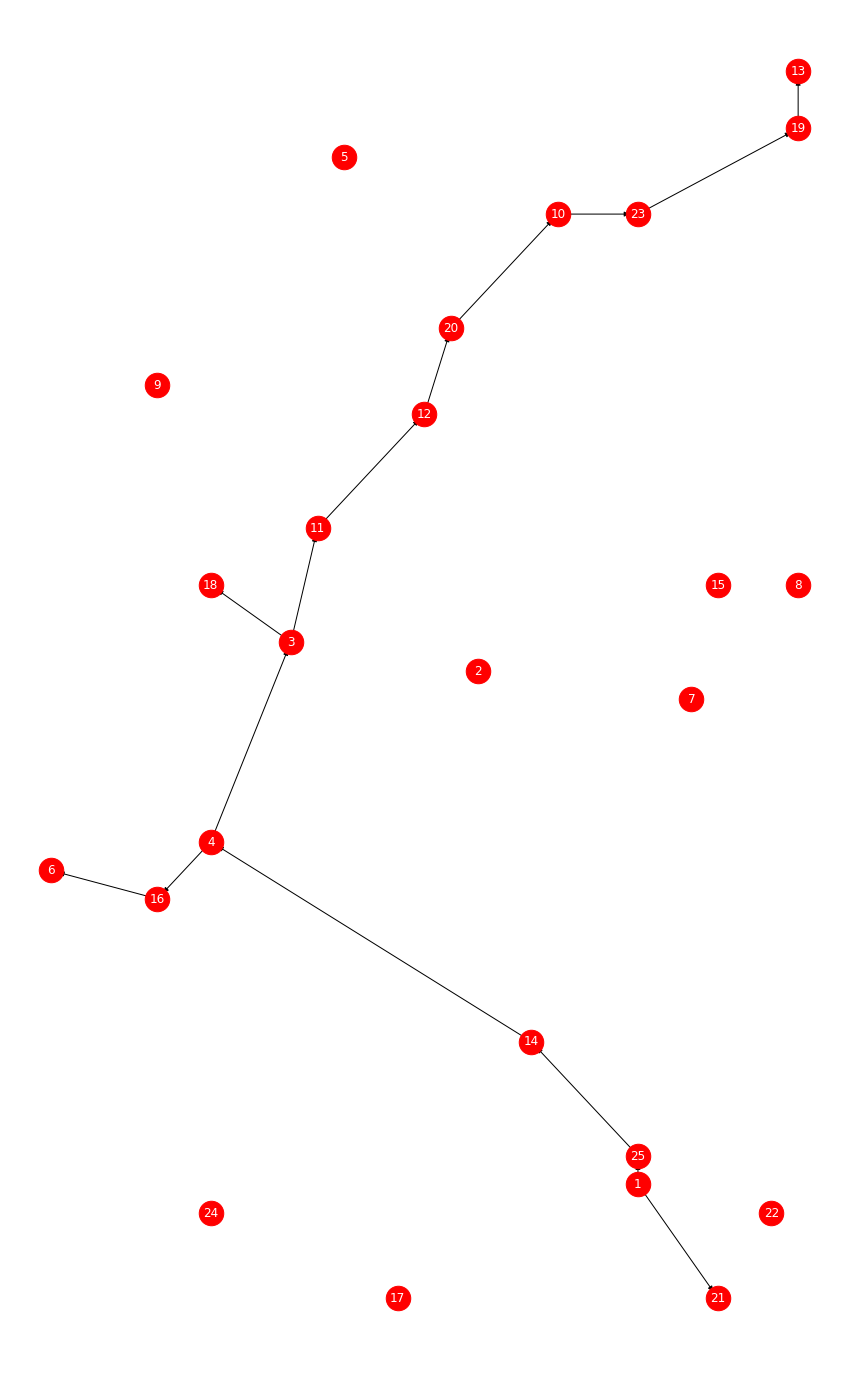

In [53]:
DrawSol(D, x_2)

## Exercise 2

The graph ``atsp04062019R2.gml`` represents a logistic distribution network. Each arc has a cost \[``dist`` attribute in the graph\]. Suppose that each node (excluding the nodes 1, 10 and 20) represents a customer that demands exactly one unit of a good and that the company owns a vehicle with capacity C=8. Compare the following distribution strategies: 

1. Goods are stored only in node 1 (cost: 120 Euro per unit) and delivers are split in three different tours. 
2. Good are stored as in Q1 but the optimal tour must contain the sequence of nodes:  18 $\rightarrow$ 9 $\rightarrow$  1.
3. Goods are stored(equally divided) in nodes 1 (cost: 120 Euro per unit), 10 (cost 150 Euro per unit) and 20 (cost 200 Euro per unit) and node 10 is visited before node 20. 

For each alternative report the optimal solution, the value of the linear relaxation and the number of enumerated nodes.

First we read the graph

In [82]:
# 
# Read the graph in the graphML format
#


args.filename = 'atsp04062019R2.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (20,20)

#print(G.edges(data=True))

G has 27 nodes and 702 edges
True


In [59]:
G.nodes()

NodeView((1, 2, 3, 4, 10, 6, 7, 8, 9, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 21, 20, 23, 24, 25, 26, 27))

## Strategy 1

The graph has 27 nodes. 24 nodes  require goods delivery (all nodes of the graph but nodes 1, 10 and 20). 
Thus, you can solve the first question
by applying the mTSP model with maximum lenght of each subtour equal to 8 (vehicle capacity)

Thus, we use the MTZ formulation

### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [63]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (20,20)

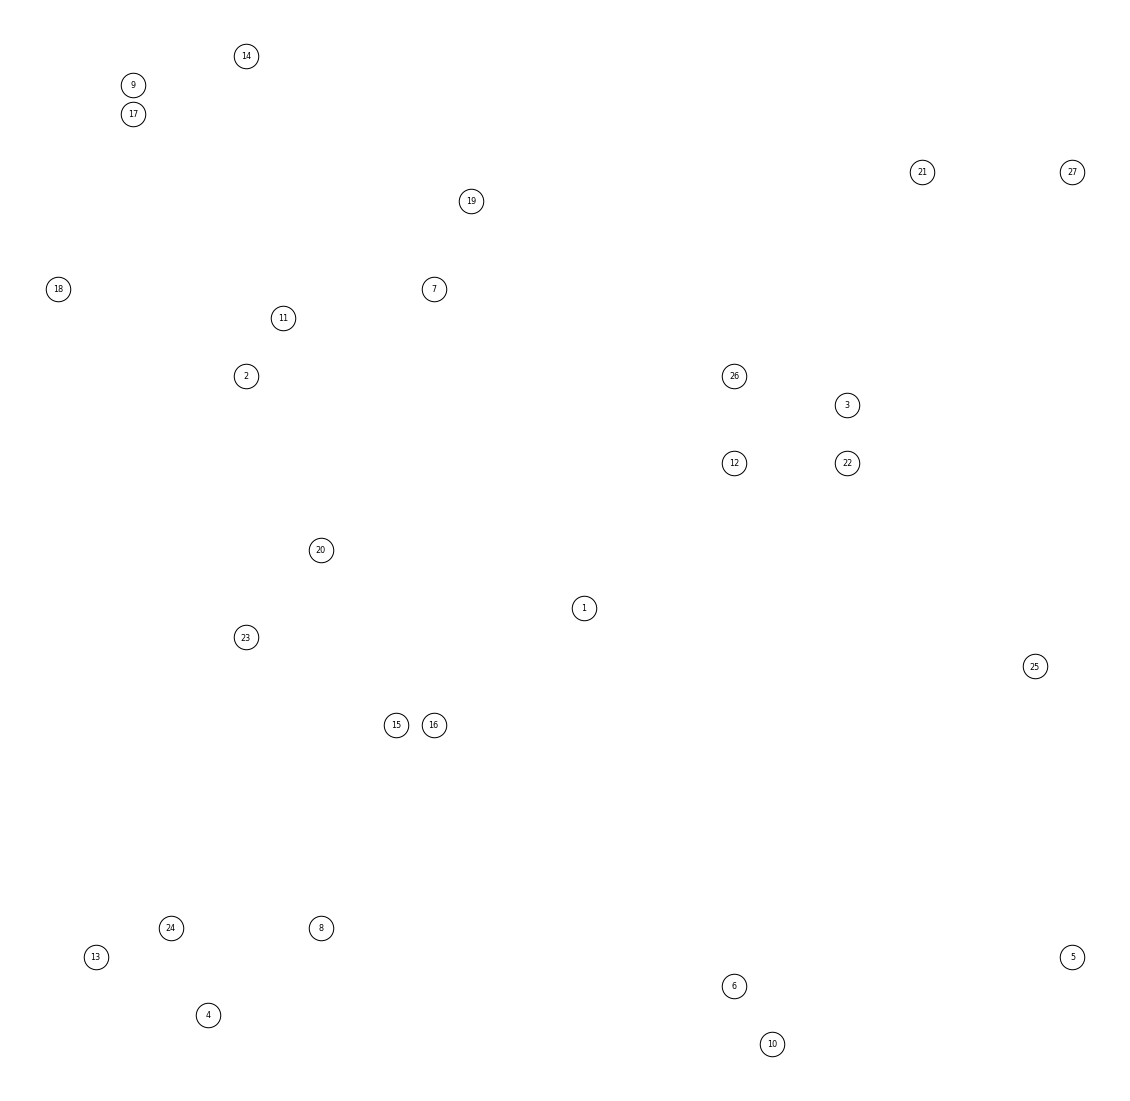

In [64]:
root = 1

DrawInitG(G)

### First remove from G nodes 10 and 20

In [65]:
G.remove_nodes_from([10, 20])
G.number_of_nodes()

25

In [68]:
#
# Number of subtours
#

m = 3

#
# Max subtuor length
#


p = 8

In [69]:
mtsp_mtz = gb.Model()

x = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')
mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

u[root].lb = 0
u[root].ub = 0

mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [72]:
mtsp_mtz.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 878 rows, 625 columns and 3408 nonzeros
Model fingerprint: 0x1c6f0918
Variable types: 25 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 7e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 878 rows, 624 columns, 3408 nonzeros
Variable types: 24 continuous, 600 integer (600 binary)

Root relaxation: objective 1.546400e+04, 95 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 15464.0000    0   30          - 15464.0000      -     -    0s
H    0     0                    44187.000000 15495.0000  64.9%     -    0s
     0     0 15495.0000   

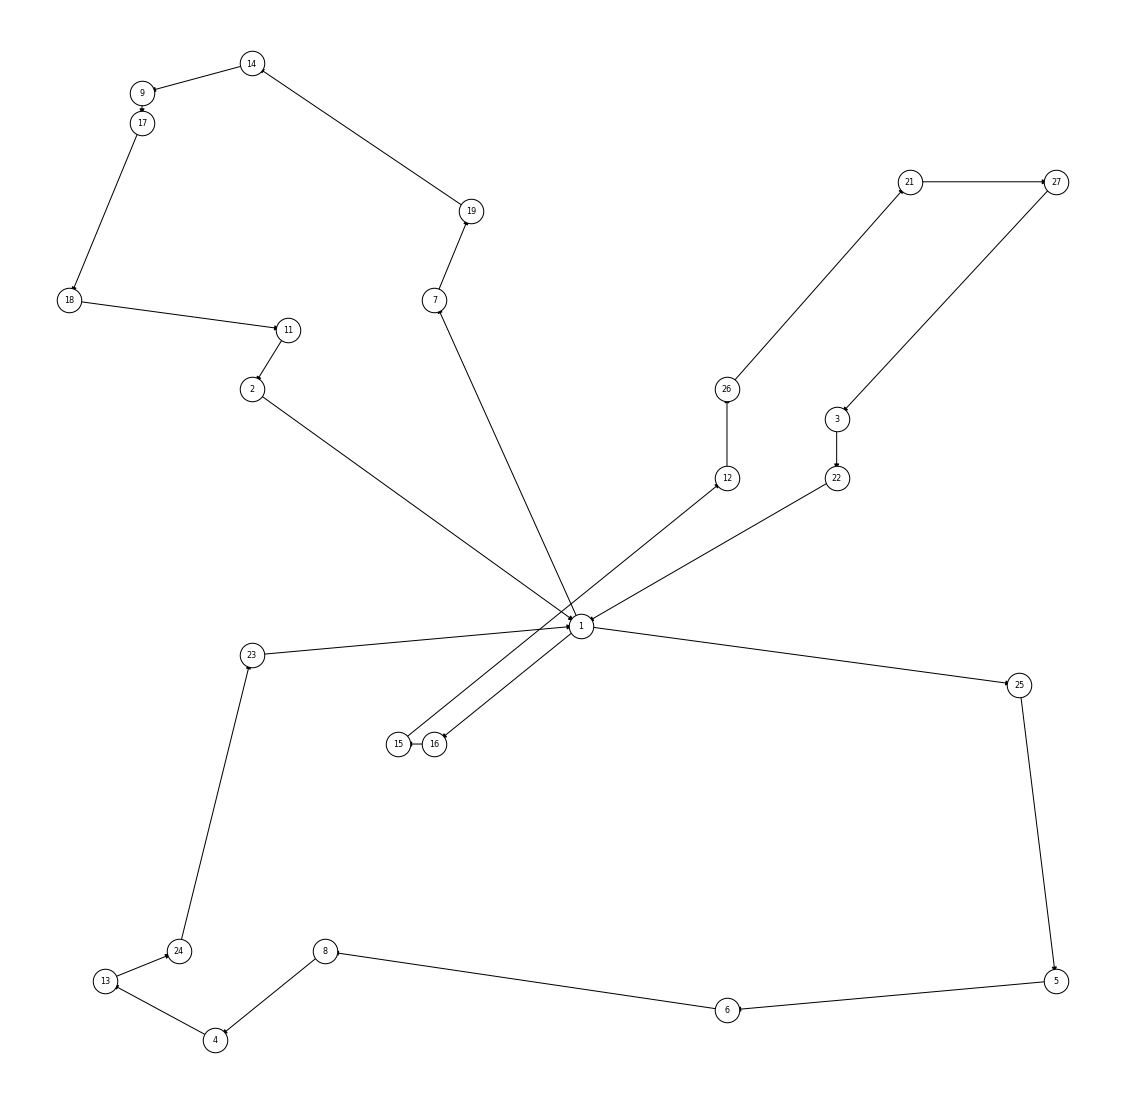

In [73]:
## Solution analysis

DrawSol(G, x)

## Strategy cost

Delivery: 18081

Storage: 24 * 120 = 2880

Total cost: 20961


## Strategy 2 

Same as Strategy 1, but arc (18,9) and arc (9,1) must stay in the final solution

In [75]:
x[18,9].lb = 1
x[9,1].lb = 1

mtsp_mtz.update()

mtsp_mtz.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 878 rows, 625 columns and 3408 nonzeros
Model fingerprint: 0x98f73b24
Variable types: 25 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 7e+00]

MIP start from previous solve produced solution with objective 19550 (0.01s)
Loaded MIP start from previous solve with objective 19550

Presolve removed 116 rows and 74 columns
Presolve time: 0.01s
Presolved: 762 rows, 551 columns, 2950 nonzeros
Variable types: 22 continuous, 529 integer (529 binary)

Root relaxation: objective 1.771212e+04, 110 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17712.1250    0   16 1

Delivery cost obviously increases from 18081 to 19550

## Strategy 3

Here we resort to the ATSP model. In fact, the vehicle starts from node 1,
loads 8 items of the good, travels for 8 nodes up to node 10, then in node 10 loads further 8 items and travels up to node 20 where it loads the last 8 items and goes back to node 1.  
Node 10 must stay in position 10 in the tour and node 20 must stay in position 19. 

**Don't forget to read back the graph as we removed 2 nodes in the previous strategies**

In [101]:
args.filename = 'atsp04062019R2.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (20,20)

G has 27 nodes and 702 edges
True


In [102]:
atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),
                     obj=[G[i][j]['dist'] for i,j in G.edges()],
                     vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS,
                     name='u')

atsp_mtz.write('atsp_mtz.lp')

atsp_mtz.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')

atsp_mtz.update()


atsp_mtz.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')

atsp_mtz.update()


atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != root) and (j !=root) \
                     and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [103]:
u[root].lb = 1.0
u[root].ub = 1.0

u[10].lb = 10
u[10].ub = 10

u[20].lb = 19
u[20].ub = 19



In [104]:
atsp_mtz.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 704 rows, 729 columns and 4004 nonzeros
Model fingerprint: 0xa90bc563
Variable types: 27 continuous, 702 integer (702 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 2 rows and 5 columns
Presolve time: 0.01s
Presolved: 702 rows, 724 columns, 3896 nonzeros
Variable types: 24 continuous, 700 integer (700 binary)

Root relaxation: objective 1.353331e+04, 111 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13533.3077    0   42          - 13533.3077      -     -    0s
     0     0 13563.7769    0   50          - 13563.7769      -     -    0s
     0     0 13666.5000  

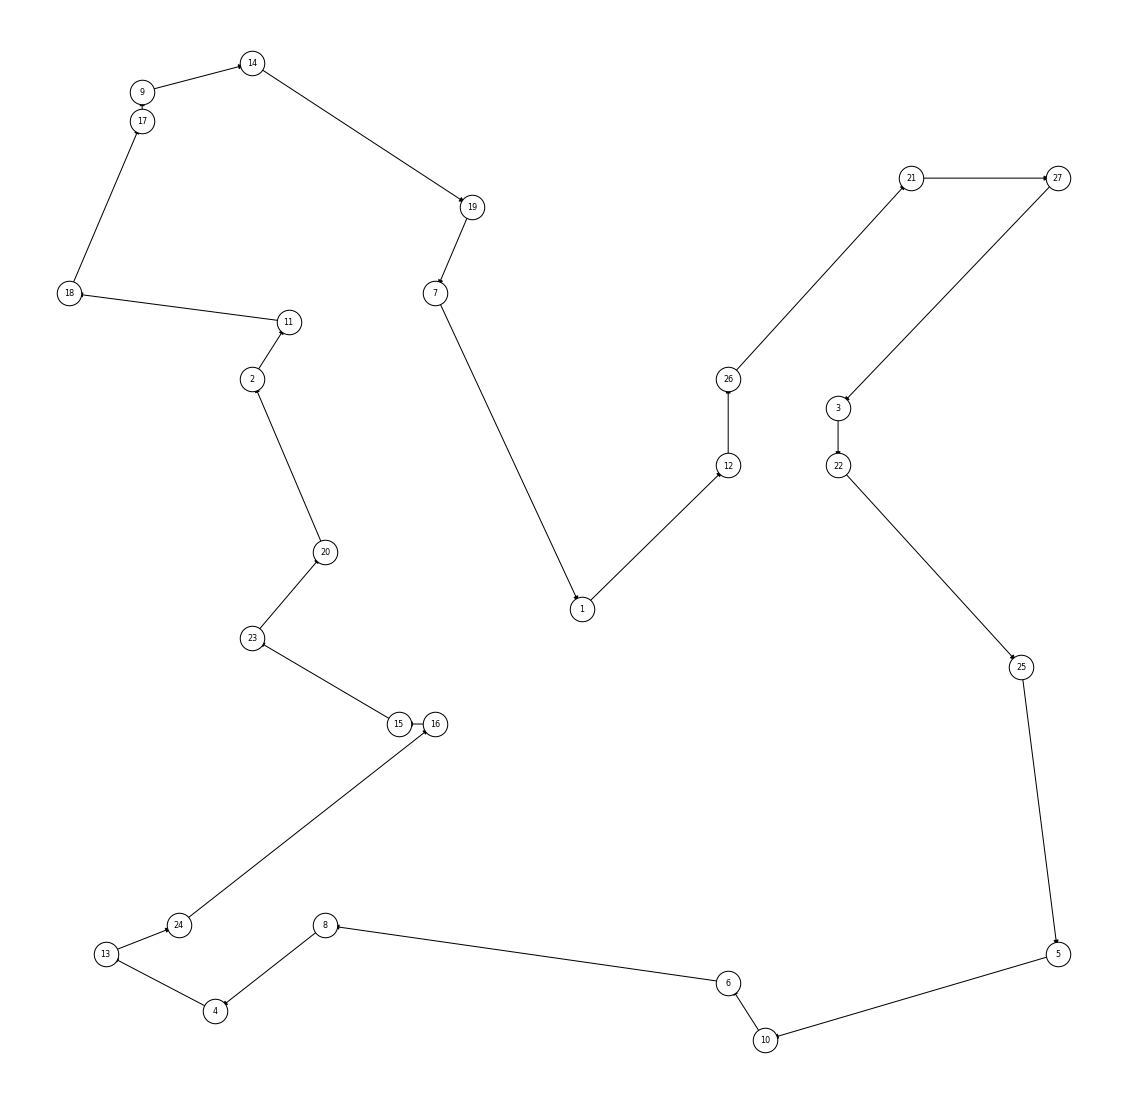

In [105]:
DrawSol(G, x)

## Solution analysis


Delivery cost: 15293

Storage cost: 120 * 8 + 150 * 8 + 200 * 8 = 6160

Total cost: 21453
    
